In [ ]:
# To use these functions, run all of the cells up to the master cell, then call any desired functions 
# using the master cell.

%matplotlib inline

import math
import time
import datetime
from operator import itemgetter
import gc
from os import walk
from os import path
import csv

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ColorConverter
import seaborn as sns
import numpy as np
import pandas as pd
import urllib2
from StringIO import StringIO
import requests
from scipy.interpolate import spline
import pyfits

In [ ]:
def getHinodeFlareCat(time1,time2,fm=False,fmn=False,fme=False,nm=False):
    '''Return a pandas dataframe containing the Hinode Flare Catalog data from between time1 and time2.
    
    Arguments:
    time1 -- The initial time boundary (datetime object)
    time2 -- The final time boundary (datetime object)
    
    Keyword Arguments:
    fm -- Focus Mode only (default False)
    fmn -- Normal Focus Mode (not eclipse season) only (default False)
    fme -- Eclipse season Focus Mode only (default False)
    nm -- Normal mode only (default False)'''
    
    time1 = time1.strftime('%Y/%m/%d %H:%M')
    time2 = time2.strftime('%Y/%m/%d %H:%M')
    
    # Read csv file and store data in a csv file
    f = urllib2.urlopen('http://st4a.stelab.nagoya-u.ac.jp/hinode_flare/csv/all_event.csv')
    strio = StringIO(requests.get('http://st4a.stelab.nagoya-u.ac.jp/hinode_flare/csv/all_event.csv').content)
    df = pd.read_csv(strio,error_bad_lines=False)
    
    df.columns = ['num','t_start','t_end','t_peak','loc','class','x','y','SOT','SP','XRT','EIS','RHESSI','SUZAKU/WAM','NoRH']
    
    # Focus mode time ranges
    if fm or nm:
        tFocus = [('2014/01/11 09:00','2014/02/08 09:00'),('2014/05/31 09:00','2014/06/28 09:00'),
                  ('2014/12/16 09:00','2015/01/05 09:00'),('2015/01/12 09:00','2015/02/03 09:00'),
                  ('2015/05/25 09:00','2015/06/16 09:00'),('2015/06/22 09:00','2015/07/14 09:00'),
                  ('2015/07/20 09:00','2015/08/10 09:00')]
    
    if fme:
        tFocus = [('2014/05/31 09:00','2014/06/28 09:00'),('2015/05/25 09:00','2015/06/16 09:00'),
                  ('2015/06/22 09:00','2015/07/14 09:00'),('2015/07/20 09:00','2015/08/10 09:00')]
    
    if fmn:
        tFocus = [('2014/01/11 09:00','2014/02/08 09:00'),('2014/12/16 09:00','2015/01/05 09:00'),
                  ('2015/01/12 09:00','2015/02/03 09:00')]

    
    # Used to for focus mode related filtering
    drop = []
    if fm or fmn or fme or nm:
        for i in range(len(df)):
            t = df['t_start'][i]
            for focusMode in tFocus:
                if (t > focusMode[0] and t < focusMode[1]) is not (fm or fmn or fme): 
                    if i not in drop:
                        drop.append(i)
                elif fm or fmn or fme:
                    if i in drop:
                        drop.remove(i)
                    break;
    
    # Some of these flares can break the plots
    for i,flare in df.iterrows():
        if abs(flare['y']) > 900:
            if i not in drop:
                drop.append(i)
    
    # Filter out flares outside of time1 to time2 period
    return df.drop(df.index[[drop]]).query('t_start > @time1 and t_start < @time2');

def getXrtFlareCat(time1,time2,fm=False,fmn=False,fme=False,nm=False):
    '''Return a pandas dataframe of the XRT Flare Catalog data between time1 and time2.
    Arguments are datetime objects. time1 must be prior to time2
    
    Arguments:
    time1 -- The initial time boundary (datetime object)
    time2 -- The final time boundary (datetime object)
    
    Keyword Arguments:
    fm -- Focus Mode only (default False)
    fmn -- Normal Focus Mode (not eclipse season) only (default False)
    fme -- Eclipse season Focus Mode only (default False)
    nm -- Normal mode only (default False)'''
    
    time1 = time1.strftime('%Y/%m/%d %H:%M')
    time2 = time2.strftime('%Y/%m/%d %H:%M')
    
    # An automatically generated csv is not yet available online
    # Reads csv file made by Nicole Schanche and stores data in a pandas dataframe
    df = pd.read_csv('XRT_flarecat(1).csv',error_bad_lines=False)
    df.columns = ['id','flarecat','t_start','t_end','t_peak','loc','class','x','y','SOT','XRT','EIS','RHESSI','NORH',
                  'combos','movies','response','pre_flare','obs_note','region','HEK']
    
    # Focus mode time ranges
    if fm or nm:
        tFocus = [('2014/01/11 09:00','2014/02/08 09:00'),('2014/05/31 09:00','2014/06/28 09:00'),
                  ('2014/12/16 09:00','2015/01/05 09:00'),('2015/01/12 09:00','2015/02/03 09:00'),
                  ('2015/05/25 09:00','2015/06/16 09:00'),('2015/06/22 09:00','2015/07/14 09:00'),
                  ('2015/07/20 09:00','2015/08/10 09:00')]
    
    if fme:
        tFocus = [('2014/05/31 09:00','2014/06/28 09:00'),('2015/05/25 09:00','2015/06/16 09:00'),
                  ('2015/06/22 09:00','2015/07/14 09:00'),('2015/07/20 09:00','2015/08/10 09:00')]
    
    if fmn:
        tFocus = [('2014/01/11 09:00','2014/02/08 09:00'),('2014/12/16 09:00','2015/01/05 09:00'),
                  ('2015/01/12 09:00','2015/02/03 09:00')]

    
    # Used for focus mode related filtering
    drop = []
    if fm or fmn or fme or nm:
        for i in range(len(df)):
            t = df['t_start'][i]
            for focusMode in tFocus:
                if (t > focusMode[0] and t < focusMode[1]) is not (fm or fmn or fme): 
                    if i not in drop:
                        drop.append(i)
                elif fm or fmn or fme:
                    if i in drop:
                        drop.remove(i)
                    break;
    
    # Some of these flares can break the plots
    for i,flare in df.iterrows():
        if abs(flare['y']) > 900:
            if i not in drop:
                drop.append(i)
    
    # Filter out flares outside of time period and drop all flares that are being filtered for focus mode reasons
    return df.drop(df.index[[drop]]).query('t_start > @time1 and t_start < @time2');

def split_and_purge(in_str, delim=None, purge=["", "+"]):
    """Split a string into an array of strings, removing unwanted strings."""
    pieces = []
    if delim is None:
        pieces = in_str.split()  # Split for both spaces and tabs.
    else:
        pieces = in_str.split(delim)
    return [piece for piece in pieces if piece not in purge]

def parseFlareResInfo(page):
    '''Return document as a list of tuples of datetime objects: [(t_start,t_end),...]'''
    lines = split_and_purge(page,delim='\n')
    output = []
    for line in lines[7:]:
        times = line.split()
        t1 = datetime.datetime.strptime(times[0],'%Y-%m-%dT%H:%M:%S')
        t2 = datetime.datetime.strptime(times[1],'%Y-%m-%dT%H:%M:%S')
        output.append((t1.strftime('%Y/%m/%d %H:%M'),t2.strftime('%Y/%m/%d %H:%M')))
    return output;

def getFlareModeInfo(time1,time2):
    '''Return a list of tuples of time (t_start,t_end) of flare responses between time1 and time2.
    Arguments are datetime objects. time1 must be prior to time2'''
    
    # Reads text file and stores data in info -- a list of tuples of start and end times of XRT flare trigger 
    # responses
    f = urllib2.urlopen('https://xrt.cfa.harvard.edu/missionops/flare_trigger_list/xrt_flare_responses.txt')
    strio = StringIO(requests.get('https://xrt.cfa.harvard.edu/missionops/flare_trigger_list/xrt_flare_responses.txt').content)
    flareFile = strio.read()
    info = parseFlareResInfo(flareFile)
    
    output = []
    # Filters out flares mode responses that occured outside of time1 to time2 range
    for flare in info:
        if time1.strftime('%Y/%m/%d %H:%M')<flare[0] and flare[0]<time2.strftime('%Y/%m/%d %H:%M'):
            output.append(flare)

    return output;

In [ ]:
sns.set(style="ticks")

def genHistogram(t_i,t_f,flareType,scale=False,data=pd.DataFrame(),save=False,show=True):
    '''Create a JointGrid plot showing solar flares imaged and missed by XRT. A scatterplot indicates the locations
    of flares on the sun and a heatmap indicates regions of high densities. A stacked histogram on both the x and y
    axes depicts the number of flares that were imaged and that were missed.
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    flareType -- A tuple used to filter out classes of flares
    
    Keyword arguments:
    scale -- Scale the assignment of colormap values to the heatmap based on the number of flares (default False)
    data -- A pandas dataframe of Hinode Flare Catalog data between t_i and t_f. Can be passed to speed up execution
            (default empty pandas dataframe)
    save -- A boolean indicating whether to save the generated plot (default False)
    show -- A boolean indicating whether to show the generated plot (default True)'''
    
    if data.empty:
        # Creates dataframe if not given as argument. If numerous plots are being generated, it saves a significant
        # amount of time to call getXrtFlareCat once and to pass the dataframe to the plotting functions.
        data = getXrtFlareCat(t_i,t_f)
        print 'no data passed'
    
    # Creates dataframes of flare metadata for flares of specified class(es) depending on whether XRT imaged the flare
    coorsXrt = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] > 0))][['x','y','XRT','t_start','t_end']]
    coorsMissed = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] == 0))][['x','y','XRT']]
    coorsAll = data[(data['class'] > flareType[1]) & (data['class'] < flareType[2])][['x','y','XRT']]
    
    # Creates JointGrid object and names figure and axes
    g = sns.JointGrid(coorsXrt['x'],coorsXrt['y'],size=15,xlim=[-1050,1050],ylim=[-1050,1050],ratio=4)
    
    fig = plt.gcf()
    ax_sun = g.ax_joint
    ax1 = g.ax_marg_x
    ax2 = g.ax_marg_y
    
    # Creates a background rectangle for aesthetic purposes and draws a circle to denote the sun
    ax_sun.add_patch(plt.Rectangle((-1050,-1050),2100,2100,color='#fffddb',zorder=-1,alpha=1))
    ax_sun.add_patch(plt.Circle((0,0),1920/2,color='black',alpha=1,zorder=1,fill=False))
    
    # Creates scatterplots showing flares imaged in red and missed in grey
    g.plot_joint(plt.scatter,s=30,color='red',zorder=2)
    ax_sun.scatter(coorsMissed['x'],coorsMissed['y'],s=30,color='grey',alpha=0.5,zorder=2)
    
    # Scales the heatmap based on total number of flares in scale=True is passed. Useful when generating movies.
    # Scaling equation is currently intended for 6 month time windows. The exponent combats the very dark values
    # otherwise present in plots with only a few dozen points that are very close together.
    if scale:
        vmin = 0
        vmax = 0.0000013/len(coorsAll)**1.02*3000
    else:
        vmin = vmax = None
    
    # Creates the heatmap of all flares of specified classes within time range.
    sns.kdeplot(coorsAll.dropna(subset=['x','y'],how='any')['x'],coorsAll.dropna(subset=['x','y'],how='any')['y'],
                cmap='YlOrBr',zorder=1,shade=True,vmax=vmax,vmin=vmin)    
    
    # Creates stacked histograms. NaN's are dropped because they are handled poorly by plt.hist()
    ax1.hist([coorsXrt['x'].dropna(),coorsMissed['x'].dropna()],stacked=True,
                     bins=range(-1050,1100,50),color=['red','grey'])
    ax2.hist([coorsXrt['y'].dropna(),coorsMissed['y'].dropna()],stacked=True,orientation='horizontal',
                     bins=range(-1050,1100,50),color=['red','grey'])
    
    # Positions histogram tick marks
    ymax1 = ax1.get_ylim()[1]
    xmax1 = ax2.get_xlim()[1]

    ax1.grid()
    ax1.set_yticks(range(0,int(ymax1),50))
    ax2.grid()
    ax2.set_xticks(range(0,int(xmax1),50))
    
    
    # Creates legend, title, and timestamp
    ax_sun.add_patch(plt.Rectangle((425,950),75,75,color='red',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")]))
    ax_sun.text(515,965,'Imaged: ' + str(len(coorsXrt)),size=25)

    ax_sun.add_patch(plt.Rectangle((425,850),75,75,color='grey',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")]))
    ax_sun.text(515,865,'Missed: ' + str(len(coorsMissed)),size=25)

    title = flareType[0] + ' Flares Histogram'
    fig.suptitle(title,size=50,x=0.46)
    fig.text(.065,.05,t_i.strftime('%Y-%m-%d %H:%M')+' to '+t_f.strftime('%Y-%m-%d %H:%M'),size=25)
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
    
    # Closes figure. Memory leak nonetheless still exists as of 2015-07-28
    fig.clf()
    plt.close('all')
    
    return 0;

In [ ]:
def genDistPlot(t_i,t_f,flareType,scale=False,data=pd.DataFrame(),save=False,show=True,bw=100):
    '''Create a JointGrid plot showing solar flares imaged and missed by XRT. A scatterplot indicates the locations
    of flares on the sun and a heatmap indicates regions of high densities. Spline curves depict the relative 
    densities of the sets all flare, imaged flares, and missed flares along both the x and y axes.
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    flareType -- A tuple used to filter out classes of flares
    
    Keyword arguments:
    scale -- Scale the assignment of colormap values to the heatmap based on the number of flares (default False)
    data -- A pandas dataframe of Hinode Flare Catalog data between t_i and t_f. Can be passed to speed up execution
            (default empty pandas dataframe)
    save -- A boolean indicating whether to save the generated plot (default False)
    show -- A boolean indicating whether to show the generated plot (default True)'''
    
    if data.empty:
        # Creates dataframe if not given as argument. If numerous plots are being generated, it saves a significant
        # amount of time to call getXrtFlareCat once and to pass the dataframe to the plotting functions.
        data = getXrtFlareCat(t_i,t_f)
        print 'no data passed'
    
    # Creates dataframes of flare metadata for flares of specified class(es) depending on whether XRT imaged the flare
    coorsXrt = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] > 0))][['x','y','XRT','t_start','t_end']]
    coorsMissed = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] == 0))][['x','y','XRT']]
    coorsAll = data[(data['class'] > flareType[1]) & (data['class'] < flareType[2])][['x','y','XRT']]
    
    
    fig = plt.figure()
    
    # Creates kdeplots that are used to create the spline curves
    a = sns.kdeplot(coorsAll['x'],color='yellow',legend=False,bw=bw)
    b = sns.kdeplot(coorsXrt['x'],color='red',legend=False,bw=bw)
    try: # Program would otherwise fail if no flares were missed
        c = sns.kdeplot(coorsMissed['x'],color='grey',legend=False,bw=bw)
    except:
        c = sns.kdeplot(coorsAll['x'],color='yellow',legend=False,bw=bw) 
        # Best way I could find to mark zero flares. This solution seems nonsensical, however it is not a
        # straightfoward problem to solve because of the unusual behavior of the .get_lines()[i].get_data() 
        # function later on.
    d = sns.kdeplot(coorsAll['y'],color='yellow',legend=False,bw=bw)
    e = sns.kdeplot(coorsXrt['y'],color='red',legend=False,bw=bw)
    try:
        f = sns.kdeplot(coorsMissed['y'],color='grey',legend=False,bw=bw)
    except:
        f = sns.kdeplot(coorsAll['x'],color='yellow',legend=False,bw=bw)
    
    kdelist = [(a,coorsAll['x']),(b,coorsXrt['x']),(c,coorsMissed['x']),(d,coorsAll['y']),(e,coorsXrt['y']),(f,coorsMissed['y'])]

    # Creates spline curves that are scaled relative to each other
    xnew = range(-1050,1050,5)
    splines = []
    for i in range(len(kdelist)): #scales kdeplot data and creates spline curves
        x = list(kdelist[i][0].get_lines()[i].get_data()[0])
        y = list(kdelist[i][0].get_lines()[i].get_data()[1])
        tempy=[]
        for j in range(len(y)):
            tempy.append(y[j] * len(kdelist[i][1]))
        splines.append(spline(x,tempy,xnew))
    
    for axis in fig.axes:
        axis.cla()
    
    fig.clf()
    plt.close(fig)
    
    # Creates JointGrid object and names figure and axes
    g = sns.JointGrid(coorsXrt['x'],coorsXrt['y'],size=15,xlim=[-1050,1050],ylim=[-1050,1050],ratio=4)
    
    fig = plt.gcf()
    ax_sun = g.ax_joint
    ax1 = g.ax_marg_x
    ax2 = g.ax_marg_y
    
    # Creates a background rectangle for aesthetic purposes and draws a circle to denote the sun
    ax_sun.add_patch(plt.Rectangle((-1050,-1050),2100,2100,color='#ffffe5',zorder=-1,alpha=1))
    ax_sun.add_patch(plt.Circle((0,0),1920/2,color='black',alpha=1,zorder=1,fill=False))
    
    # Creates scatterplots showing flares imaged in red and missed in grey
    g.plot_joint(plt.scatter,s=30,color='red',zorder=2)
    ax_sun.scatter(coorsMissed['x'],coorsMissed['y'],s=30,color='grey',alpha=0.5,zorder=2)
    
    # Scales the heatmap based on total number of flares in scale=True is passed. Useful when generating movies.
    # Scaling equation is currently intended for 6 month time windows. The exponent combats the very dark values
    # otherwise present in plots with only a few dozen points that are very close together.
    if scale:
        vmin = 0
        vmax = 0.0000013/len(coorsAll)**1.02*3000
    else:
        vmin = vmax = None
    
    # Creates the heatmap of all flares of specified classes within time range.
    sns.kdeplot(coorsAll.dropna(subset=['x','y'],how='any')['x'],coorsAll.dropna(subset=['x','y'],how='any')['y'],
                cmap='YlOrBr',zorder=1,shade=True,vmax=vmax,vmin=vmin)    

    # Plots spline curves and shades underneath them
    if scale:
        ax1.axis([-1050,1050,0,0.5*3])
        ax2.axis([0,4.0,-1050,1050])
    
    ax1.plot(xnew,splines[0],axes=ax1,color='yellow')
    ax1.fill_between(xnew,0,list(splines[0]),color='yellow',alpha=0.3)

    ax1.plot(xnew,splines[1],axes=ax1,color='red')
    ax1.fill_between(xnew,0,list(splines[1]),color='red',alpha=0.3)

    if list(splines[2]) != list(splines[0]):
        ax1.plot(xnew,splines[2],axes=ax1,color='grey')
        ax1.fill_between(xnew,0,list(splines[2]),color='grey',alpha=0.3)
    
    ax2.plot(splines[3],xnew,axes=ax2,color='yellow')
    ax2.fill_between(list(splines[3]),1200,xnew,color='yellow',alpha=0.3)

    ax2.plot(splines[4],xnew,axes=ax2,color='red')
    ax2.fill_between(list(splines[4]),1200,xnew,color='red',alpha=0.3)

    if splines[5].all() != splines[0].all():
        ax2.plot(splines[5],xnew,axes=ax2,color='grey')
        ax2.fill_between(list(splines[5]),1200,xnew,color='grey',alpha=0.3)    
    
    # Creates legend
    ax_sun.add_patch(plt.Rectangle((425,950),75,75,color='yellow',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=2))
    ax_sun.text(515,965,flareType[0]+' Flares: '+ str(len(coorsAll)),size=25,zorder=2)

    ax_sun.add_patch(plt.Rectangle((425,850),75,75,color='red',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=2))
    ax_sun.text(515,865,'Imaged: ' + str(len(coorsXrt)),size=25,zorder=2)
    
    ax_sun.add_patch(plt.Rectangle((425,750),75,75,color='grey',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=2))
    ax_sun.text(515,765,'Missed: ' + str(len(coorsMissed)),size=25,zorder=2)

    
    title = flareType[0] + ' Flares'
    fig.suptitle(title,size=50,x=0.42)
    fig.text(.065,.05,t_i.strftime('%Y-%m-%d %H:%M:%S')+' to '+t_f.strftime('%Y-%m-%d %H:%M:%S'),size=25)
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
    
    # Closes plot (in theory). Memory leak nonetheless still exists as of 2015-07-28
    fig.clf()
    plt.close(fig)
    
    return 0;

In [ ]:
def genProbPlot(t_i,t_f,flareType,scale=False,data=pd.DataFrame(),save=False,show=True,bw=100):
    '''Create a JointGrid plot showing solar flares imaged and missed by XRT. A scatterplot indicates the locations
    of flares on the sun and a heatmap indicates regions of high densities. A spline curve indicates the probability
    of detecting a flare along the x axis.
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    flareType -- A tuple used to filter out classes of flares
    
    Keyword arguments:
    scale -- Scale the assignment of colormap values to the heatmap based on the number of flares (default False)
    data -- A pandas dataframe of Hinode Flare Catalog data between t_i and t_f. Can be passed to speed up execution
            (default empty pandas dataframe)
    save -- A boolean indicating whether to save the generated plot (default False)
    show -- A boolean indicating whether to show the generated plot (default True)'''
    
    if data.empty:
        # Creates dataframe if not given as argument. If numerous plots are being generated, it saves a significant
        # amount of time to call getXrtFlareCat once and to pass the dataframe to the plotting functions.
        data = getXrtFlareCat(t_i,t_f)
        print 'no data passed'
    
    # Creates dataframes of flare metadata for flares of specified class(es) depending on whether XRT imaged the flare
    coorsXrt = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] > 0))][['x','y','XRT','t_start','t_end']]
    coorsMissed = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] == 0))][['x','y','XRT']]
    coorsAll = data[(data['class'] > flareType[1]) & (data['class'] < flareType[2])][['x','y','XRT']]
    
    # Creates kdeplots from which to pull unscaled datapoints for spline curves
    fig = plt.figure()
    
    a = sns.kdeplot(coorsAll['x'],color='yellow',bw=bw)
    b = sns.kdeplot(coorsXrt['x'],color='red',bw=bw)
    try:
        c = sns.kdeplot(coorsMissed['x'],color='grey',bw=bw)
    except:
        c = sns.kdeplot(coorsAll['x'],color='yellow',bw=bw)
    d = sns.kdeplot(coorsAll['y'],color='yellow',bw=bw)
    e = sns.kdeplot(coorsXrt['y'],color='red',bw=bw)
    try:
        f = sns.kdeplot(coorsMissed['y'],color='grey',bw=bw)
    except:
        f = sns.kdeplot(coorsAll['x'],color='yellow',bw=bw)

    kdelist = [(a,coorsAll['x']),(b,coorsXrt['x']),(c,coorsMissed['x']),(d,coorsAll['y']),
               (e,coorsXrt['y']),(f,coorsMissed['y'])]

    # Create scaled spline curves
    xnew = range(-1050,1050,5)
    splines = []
    for i in range(len(kdelist)):
        x = list(kdelist[i][0].get_lines()[i].get_data()[0])
        y = list(kdelist[i][0].get_lines()[i].get_data()[1])
        tempy=[]
        for j in range(len(y)):
            tempy.append(y[j] * len(kdelist[i][1])/len(coorsAll['x']))
        splines.append(spline(x,tempy,xnew))
    
    fig.clf()
    plt.close(fig)
    
    # Create JointGrid object and name figure and axes
    g = sns.JointGrid(coorsXrt['x'],coorsXrt['y'],size=15,xlim=[-1050,1050],ylim=[-1050,1050],ratio=4)
    
    fig = plt.gcf()
    
    ax_sun = g.ax_joint
    ax1 = g.ax_marg_x
    ax2 = g.ax_marg_y

    ax_sun.add_patch(plt.Rectangle((-1050,-1050),2100,2100,color='#fffddb',zorder=-1,alpha=1))
    ax_sun.add_patch(plt.Circle((0,0),1920/2,color='black',alpha=1,zorder=1,fill=False))

    # Scale heatmap if scale=True is passed
    if scale:
        vmin = 0
        vmax = 0.0000013/len(coorsAll)**1.02*3000
    else:
        vmin = vmax = None
    
    # Create primary plot features
    g.plot_joint(plt.scatter,s=30,color='red',zorder=12)
    sns.kdeplot(coorsAll.dropna(subset=['x','y'],how='any')['x'],coorsAll.dropna(subset=['x','y'],how='any')['y'],
                cmap='YlOrBr',zorder=1,shade=True,vmax=vmax,vmin=vmin)
    
    ax_sun.scatter(coorsMissed['x'],coorsMissed['y'],s=30,color='grey',alpha=0.5,zorder=2)

    
    # Create secondary plot features
    ax1.axis([-1050,1050,0,1])
    ax1.plot(xnew,splines[1]/splines[0],color='red')
    ax1.fill_between(xnew,0,list(splines[1]/splines[0]),color='red',alpha=0.3)
    ax1.grid()

    ax1.set_yticks([0.0,0.25,0.5,0.75,1.0])
    
    
    # Create legends/titles/timestamp
    ax_sun.add_patch(plt.Rectangle((425,950),75,75,color='red',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")]))
    ax_sun.text(515,965,'Imaged: ' + str(len(coorsXrt)),size=25)

    ax_sun.add_patch(plt.Rectangle((425,850),75,75,color='grey',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")]))
    ax_sun.text(515,865,'Missed: ' + str(len(coorsMissed)),size=25)
    
    title = flareType[0] + ' Flare Imaging Probability'
    fig.suptitle(title,size=50,x=0.42)
    
    fig.text(.065,.05,t_i.strftime('%Y-%m-%d %H:%M')+' to '+t_f.strftime('%Y-%m-%d %H:%M'),size=25)

    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
    
    fig.clf()
    plt.close(fig)
    
    return 0;

In [ ]:
def genFlareResPlot(t_i,t_f,flareType,scale=False,data=pd.DataFrame(),save=False,show=True,bw=100):
    '''Create a JointGrid plot showing solar flares imaged and missed by XRT. A scatterplot indicates the locations
    of flares imaged by XRT, distinguishing between flares imaged as a result of normal pointings and flares
    imaged in response to an XRT flare trigger
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    flareType -- A tuple used to filter out classes of flares
    
    Keyword arguments:
    scale -- Scale the assignment of colormap values to the heatmap based on the number of flares (default False)
    data -- A pandas dataframe of Hinode Flare Catalog data between t_i and t_f. Can be passed to speed up execution
            (default empty pandas dataframe)
    save -- A boolean indicating whether to save the generated plot (default False)
    show -- A boolean indicating whether to show the generated plot (default True)'''
    
    if data.empty:
        # Creates dataframe if not given as argument. If numerous plots are being generated, it saves a significant
        # amount of time to call getXrtFlareCat once and to pass the dataframe to the plotting functions.
        data = getXrtFlareCat(t_i,t_f)
        print 'no data passed'
    
    # Creates dataframes of flare metadata for flares of specified class(es) depending on whether XRT imaged the flare
    coorsXrt = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] > 0))][['x','y','XRT','t_start','t_end']]
    coorsMissed = data[((data['class'] > flareType[1]) & (data['class'] < flareType[2]) & 
                     (data['XRT'] == 0))][['x','y','XRT']]
    coorsAll = data[(data['class'] > flareType[1]) & (data['class'] < flareType[2])][['x','y','XRT']]
    
    # Create pandas dataframe of flare trigger response coordinates
    flareResponseInfo = getFlareModeInfo(t_i,t_f)
    flareResX = []
    flareResY = []
    for i,flare in coorsXrt.iterrows():
        for response in flareResponseInfo:
            if ((response[0] > flare['t_start'] and response[0] < flare['t_end']) or 
                (response[1] > flare['t_start'] and response[1] < flare['t_end'])):
                
                flareResX.append(flare['x'])
                flareResY.append(flare['y'])
                break;
    
    flareResponses=pd.DataFrame({'x':flareResX,'y':flareResY})
    
    fig = plt.figure()
    
    #Creates kdeplots
    a = sns.kdeplot(coorsAll['x'],color='yellow',legend=False,bw=bw)
    b = sns.kdeplot(coorsXrt['x'],color='red',legend=False,bw=bw)
    try: #Program would otherwise fail if no flares were missed
        c = sns.kdeplot(coorsMissed['x'],color='grey',legend=False,bw=bw)
    except:
        c = sns.kdeplot(coorsAll['x'],color='yellow',legend=False,bw=bw) 
        #Best way I could find to mark zero flares. This solution seems nonsensical, however it is not a straightforward
        #problem to solve because of the unusual behavior of the .get_lines()[i].get_data() function later on.
    d = sns.kdeplot(coorsAll['y'],color='yellow',legend=False,bw=bw)
    e = sns.kdeplot(coorsXrt['y'],color='red',legend=False,bw=bw)
    try:
        f = sns.kdeplot(coorsMissed['y'],color='grey',legend=False,bw=bw)
    except:
        f = sns.kdeplot(coorsAll['x'],color='yellow',legend=False,bw=bw)

    g = sns.kdeplot(flareResponses['x'],color='orange',legend=False,bw=bw)
    h = sns.kdeplot(flareResponses['y'],color='orange',legend=False,bw=bw)

    
    
    kdelist = [(a,coorsAll['x']),(b,coorsXrt['x']),(c,coorsMissed['x']),(d,coorsAll['y']),(e,coorsXrt['y']),
               (f,coorsMissed['y']),(g,flareResponses['x']),(h,flareResponses['y'])]
    
    # Creates scaled spline curves
    xnew = range(-1050,1050,5)
    splines = []
    for i in range(len(kdelist)):
        x = list(kdelist[i][0].get_lines()[i].get_data()[0])
        y = list(kdelist[i][0].get_lines()[i].get_data()[1])
        tempy=[]
        for j in range(len(y)):
            tempy.append(y[j] * len(kdelist[i][1])/len(coorsAll['x']))
        splines.append(spline(x,tempy,xnew))
    
    fig.clf()
    plt.close()
    
    # Create JointGrid object
    g = sns.JointGrid(coorsXrt['x'],coorsXrt['y'],size=15,xlim=[-1050,1050],ylim=[-1050,1050],ratio=4)
    
    fig = plt.gcf()
    
    ax_sun = g.ax_joint
    ax1 = g.ax_marg_x
    ax2 = g.ax_marg_y
    
    # The purpose of the unusually high zorder numbers is to hide unwanted features that I struggled with removing
    ax_sun.add_patch(plt.Rectangle((-1050,-1050),2100,2100,color='#fffddb',zorder=10,alpha=0.7))
    ax_sun.add_patch(plt.Circle((0,0),1920/2,color='black',alpha=1,zorder=12,fill=False))

    # Scale heatmap if scale=True is passed
    if scale:
        vmin = 0
        vmax = 0.0000013/len(coorsAll)**1.02*3000
    else:
        vmin = vmax = None
    
    # Creates primary plot features
    g.plot_joint(plt.scatter,s=30,color='red',zorder=12,alpha=1)
    sns.kdeplot(coorsXrt.dropna(subset=['x','y'],how='any')['x'],coorsXrt.dropna(subset=['x','y'],how='any')['y'],
                cmap='YlOrBr',zorder=11,shade=True,vmax=vmax,vmin=vmin)

    plt.scatter(flareResponses['x'],flareResponses['y'],s=30,color='orange',zorder=12,alpha=1)

    
    # Creates secondary plot features
    ax1.axis([-1050,1050,0,max(splines[1])])

    ax1.plot(xnew,splines[1],axes=ax1,color='red')
    ax1.fill_between(xnew,0,list(splines[1]),color='red',alpha=0.3)
        
    if list(splines[6]) != list(splines[0]):
        ax1.plot(xnew,splines[6],color='orange')
        ax1.fill_between(xnew,0,list(splines[6]),color='orange',alpha=0.3)

    ax2.plot(splines[4],xnew,axes=ax2,color='red')
    ax2.fill_between(list(splines[4]),1200,xnew,color='red',alpha=0.3) 
    
    if list(splines[7]) != list(splines[0]):
        ax2.plot(splines[7],xnew,color='orange')
        ax2.fill_between(list(splines[7]),1200,xnew,color='orange',alpha=0.3)
    
    # Creates legend, title, and timestamp
    ax_sun.add_patch(plt.Rectangle((425,950),75,75,color='red',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=11))
    ax_sun.text(515,965,'Imaged: ' + str(len(coorsXrt)),size=25,zorder=11)
    
    ax_sun.add_patch(plt.Rectangle((425,850),75,75,color='orange',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=11))
    ax_sun.text(515,865,'FR Images: ' + str(len(flareResponses['x'])),size=25,zorder=11)

    
    title = flareType[0] + ' Flares FR Plot'
    fig.suptitle(title,size=50,x=0.42)
    fig.text(.065,.05,t_i.strftime('%Y-%m-%d %H:%M')+' to '+t_f.strftime('%Y-%m-%d %H:%M'),size=25)
    
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
        
    plt.close('all')
    
    return 0;

In [ ]:
# Not particularly useful

def genFRPercentPlot(t_i,t_f,save=False,show=True):
    '''Create a stacked bar plot showing the percent of flares imaged by XRT and the percent imaged during a flare
    response. The bar plot is broken down by the classes of flares that occured in the time period of question.
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    
    Keyword arguments:
    save -- A boolean indicating whether to save the resulting plot (default False)
    show -- A boolean indicating whether to show the resulting plot (default True)'''
    
    # Create pandas dataframe of flare response instances
    data = getXrtFlareCat(t_i,t_f)
    flareResponses = data[data['response'] > 0]
    
    # Create figure
    fig = plt.figure(figsize=(15,15))
    
    # Create and sort a list of classes of flares that occured, truncating to form C2, X3, etc.
    powersAll = []
    for flareClass in data['class']:
        powersAll.append(flareClass.split('.')[0])
    powersAll.sort()
    
    # Same as above but for flares imaged
    powersXrt = []
    for i,flare in data[data['XRT'] > 0].iterrows():
        powersXrt.append(flare['class'].split('.')[0])
    powersXrt.sort()
    
    # Same as above but for flares missed
    powersFR = list(flareResponses['class'])
    for i in range(len(powersFR)):
        powersFR[i] = powersFR[i].split('.')[0]
    powersFR.sort()
    
    indicesAll = []
    freqsAll = []
    for power in powersAll:
        added = False
        for i in range(len(indicesAll)):
            if power == indicesAll[i]:
                freqsAll[i] += 1.0
                added = True
        if not added:
            indicesAll.append(power)
            freqsAll.append(1.0)
            
    indicesXrt = indicesAll
    freqsXrt = [0.0]*len(indicesAll)
    for power in powersXrt:
        for i in range(len(indicesXrt)):
            if power == indicesXrt[i]:
                freqsXrt[i] += 1.0
    
    indicesFR = indicesAll
    freqsFR = [0.0]*len(indicesAll)
    for power in powersFR:
        for i in range(len(indicesFR)):
            if power == indicesFR[i]:
                freqsFR[i] += 1.0
    
    percentsXrt = []
    for a,b in zip(freqsXrt,freqsAll):
        try:
            percentsXrt.append(a/b*100)
        except ZeroDivisionError:
            percentsXrt.append(0.0)
    
    percentsFR = []
    for a,b in zip(freqsFR,freqsAll):
        try:
            percentsFR.append(a/b*100)
        except ZeroDivisionError:
            percentsFR.append(0.0)
    
    ind = np.arange(len(indicesAll))
    
    ax = plt.gca()
    ax.bar(ind,percentsXrt,color='red',zorder=1)
    ax.bar(ind,percentsFR,color='orange',zorder=2)
    ax.set_xticks(ind+0.4)
    ax.set_xticklabels(indicesAll,size=20)
    ax.set_yticklabels(range(0,110,20),size=20)
    ax.grid()
    ax.set_xlabel('Flare Class',size=30)
    ax.set_ylabel('Percent',size=30,rotation=90)
    
    title='Flare Imaging Success'
    fig.suptitle(title, size=50)
    
    ax.text(.5,96,t_i.strftime('%Y-%m-%d %H:%M:%S') + ' to ' + t_f.strftime('%Y-%m-%d %H:%M:%S'),size=25)
    ax.add_patch(plt.Rectangle((.5,92),1,3,color='red',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=2))
    ax.text(1.75,93,'Imaged',size=25,zorder=2)
    
    ax.add_patch(plt.Rectangle((.5,88),1,3,color='orange',
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=2))
    ax.text(1.75,88,'FR Image',size=25,zorder=11)
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
        
    fig.clf()
    plt.close('all')
    
    return 0;


In [ ]:
def genFRValuePlot(t_i,t_f,save=False,show=True):
    '''Create stacked bar plots depicting the numbers of flares imaged by XRT and the number of flares imaged by
    XRT as a flare response. Broken down into a class B and C plot and a class M and X plot.
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    
    Keyword arguments:
    save -- A boolean indicating whether to save the resulting plots (default False)
    show -- A boolean indicating whether to show the resulting plots (default True)'''
    
    data = getXrtFlareCat(t_i,t_f)
    flareResponses = data[data['response'] > 0]
    
    powersAll = []
    for flareClass in data['class']:
        powersAll.append(flareClass.split('.')[0])
    powersAll.sort()
    
    powersXrt = []
    for i,flare in data[data['XRT'] > 0].iterrows():
        powersXrt.append(flare['class'].split('.')[0])
    powersXrt.sort()
    
    powersFR = list(flareResponses['class'])
    for i in range(len(powersFR)):
        powersFR[i] = powersFR[i].split('.')[0]
    powersFR.sort()
    
    indicesAll = []
    freqsAll = []
    for power in powersAll:
        added = False
        for i in range(len(indicesAll)):
            if power == indicesAll[i]:
                freqsAll[i] += 1.0
                added = True
        if not added:
            indicesAll.append(power)
            freqsAll.append(1.0)
            
    indicesXrt = indicesAll
    freqsXrt = [0.0]*len(indicesAll)
    for power in powersXrt:
        for i in range(len(indicesXrt)):
            if power == indicesXrt[i]:
                freqsXrt[i] += 1.0
    
    indicesFR = indicesAll
    freqsFR = [0.0]*len(indicesAll)
    for power in powersFR:
        for i in range(len(indicesFR)):
            if power == indicesFR[i]:
                freqsFR[i] +=1.0
    
    for i in range(len(indicesAll)):
        if indicesAll[i] > 'C9':
            indices1 = indicesAll[:i]
            freqsFR1 = freqsFR[:i]
            freqsXrt1 = freqsXrt[:i]
            freqsAll1 = freqsAll[:i]
            indices2 = indicesAll[i:]
            freqsFR2 = freqsFR[i:]
            freqsXrt2 = freqsXrt[i:]
            freqsAll2 = freqsAll[i:]
            break;
    
    for indices,FR,Xrt,All in [(indices1,freqsFR1,freqsXrt1,freqsAll1),(indices2,freqsFR2,freqsXrt2,freqsAll2)]:
        ind = np.arange(len(indices))
        fig = plt.figure(figsize=(15,15))
    
        plt.bar(ind,All[:len(indices)],color='yellow',zorder=0)
        ax = plt.gca()
        ax.bar(ind,Xrt,color='red',zorder=1)
        ax.bar(ind,FR,color='orange',zorder=2)
        ax.set_xticks(ind+0.4)
        ax.set_xticklabels(indices,size=20)
        ax.grid()
        ax.set_xlabel('Flare Class',size=30)
        ax.set_ylabel('Number',size=30,rotation=90)
        title = 'Flare Imaging Success'
        fig.suptitle('Flare Imaging Success', size=50)

        ax.text(.4,.97,t_i.strftime('%Y-%m-%d %H:%M:%S') + ' to ' + t_f.strftime('%Y-%m-%d %H:%M:%S'),size=25,transform=ax.transAxes)
        ax.add_patch(plt.Rectangle((0.8,.92),.03,.03,color='yellow',transform=ax.transAxes,
                               path_effects=[PathEffects.withStroke(linewidth=2,foreground='black')],zorder=2))
        ax.text(0.84,.93,'All',size=25,zorder=2,transform=ax.transAxes)
        ax.add_patch(plt.Rectangle((.8,.88),.03,.03,color='red',transform=ax.transAxes,
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=2))
        ax.text(.84,.89,'Imaged',size=25,zorder=2,transform=ax.transAxes)
    
        ax.add_patch(plt.Rectangle((.8,.84),.03,.03,color='orange',transform=ax.transAxes,
                                    path_effects=[PathEffects.withStroke(linewidth=2,foreground="black")],zorder=2))
        ax.text(.84,.85,'FR Image',size=25,zorder=11,transform=ax.transAxes)
    
        if save:
            plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
        if show:
            plt.show()
        
        fig.clf()
        plt.close('all')
    
    return 0;

In [ ]:
# Not particularly useful

def genObsNotesPlot(t_i,t_f,pointings,save=False,show=True):
    '''Create stacked bar plots showing a breakdown of the obs_note metadata for flares missed by the XRT flare
    response for different classes of flares. Broken down into a classes B and C plot and a classes M and X plot.
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    
    Keyword arguments:
    save -- A boolean indicating whether to save the resulting plots (default False)
    show -- A boolean indicating whether to show the resulting plots (default True)'''
    
    data = getXrtFlareCat(t_i,t_f)[['class','obs_note']]
    
    missed = data[data['obs_note']<'y']
    
    obs_notes = [('no:no_hk','blue'),('no:no_timeline','black'),('no:mode=1','lightsteelblue'),('no:no_obev','cyan'),
                 ('no:orbital_event','magenta'),('no:calibration_seq','yellow'),('no:no_sci_images','red'),
                 ('no:pointing','green'),('no:mode=7','darkgoldenrod'),('no:mode=3','darkred'),('no:mode=5','khaki')]
    
    classes = []
    for i,flare in missed.iterrows():
        if flare['class'] not in classes:
            classes.append(flare['class'].split('.')[0])
    classes.sort()
    
    d1 = {flareClass:[] for flareClass in classes}
    for i,flare in missed.iterrows():
        d1[flare['class'].split('.')[0]].append(flare['obs_note'])
    
    d2 = {flareClass:[] for flareClass in classes}    
    for i,e in zip(d1.keys(),d1.values()):
        for note in e[:]:
            if note == 'no:saa' or note == 'no:ngt' or note == 'no:xtw':
                d2[i].append('no:orbital_event')
            elif note == 'no:calibration' or note == 'no:bakeout' or note == 'no:gband_only':
                d2[i].append('no:calibration_seq')
            elif note == 'no:fld_only' or note == 'no:no_obs_planned':
                d2[i].append('no:no_sci_images')
            else:
                d2[i].append(note)
                
    d3 = {flareClass:{note:0 for note in d2[flareClass]} for flareClass in d2.keys()}
    for i,e in zip(d2.keys(),d2.values()):
        for note in e:
            d3[i][note] += 1
    
    list3 = d3.keys()
    list3.sort()

    for i in range(len(list3)):
        if list3[i]>'C9':
            list2 = [list3[:i],list3[i:]]
            break;
    
    leg = []
    for list1 in list2:
        fig = plt.figure(figsize=(15,15))
        ind = np.arange(len(list1))
        bottom = [0]*len(list1)
        for note in obs_notes:
            heights = []
            for c in list1:
                try:
                    heights.append(d3[c][note[0]])
                except KeyError:
                    heights.append(0)
            b = plt.bar(ind,heights,bottom=bottom,color=note[1])
            leg.append(b[0])
            for i in range(len(bottom)):
                bottom[i] = bottom[i] + heights[i]
        plt.legend(leg,['no:no_hk','no:no_timeline','no:mode=1','no:no_obev','no:orbital_event','no:calibration_seq',
                            'no:no_sci_images','no:pointing','no:mode=7','no:mode=3','no:mode=5'],fontsize=20)
        plt.legend()
        ax = plt.gca()
        ax.set_xticks(ind+.4)
        ax.set_xticklabels(list1,size=20)
        title = 'FR Failure Reasons'
        plt.suptitle(title,size=50)
        
        if save:
            plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
        if show:
            plt.show()
        
        fig.clf()
        plt.close('all')

    return 0;  

In [ ]:
def genObsNotesClassPlot(t_i,t_f,flareType,pointings,save=False,show=True):
    '''Create a horizontal bar plot for the specified class of solar flares showing the quantity of flares that did
    not trigger a flare response broken down by obs_note metadata information.
    
    Arguments:
    t_i -- The initial time boundary (datetime object)
    t_f -- The final time boundary (datetime object)
    flareType -- Tuple indicating flare class(es) of interest e.g. ('C5 to X','C','Z')
    
    Keyword arguments:
    save -- A boolean indicating whether or not to save the resulting plot (default False)
    show -- A boolean indicating whether or not to show the resulting plot (default True)'''
    
    # Get data
    data = getXrtFlareCat(t_i,t_f)[['class','obs_note','t_start','x','y']].reset_index(drop=True)
    
    # Clarify vague obs_notes
    for i,flare in data.iterrows():
        if flare['t_start'] in reasons1415.keys():
            data.set_value(i,'obs_note',reasons1415[flare['t_start']])

    missed = data[(data['obs_note'] < 'y') & (data['class'] > flareType[1]) & (data['class'] < flareType[2])]
    
    # Dictionary to store counts of occurrences and colors
    reasons = {'no:no_hk':[0,'blue'],'no:no_timeline':[0,'black'],'no:mode=1':[0,'lightsteelblue'],'no:no_obev':[0,'cyan'],
               'no:pointing_out':[0,'darkgreen'],'no:cal_seq':[0,'yellow'],'no:no_sci':[0,'red'],'no:orbital_event':[0,'magenta'],
               'no:mode=7':[0,'darkgoldenrod'],'no:mode=3':[0,'darkred'],'no:mode=5':[0,'khaki'],'no:bakeout':[0,'orange'],
               'no:seu':[0,'grey'],'no:mwm':[0,'violet'],'no:dam':[0,'lightblue'],'no:op_error':[0,'purple'],
               'no:missing_data':[0,'black'],'no:pointing_in':[0,'lightgreen'],'no:HOP_70/130':[0,'darkgoldenrod']}
    
    # Split pointing failures based on whether the flare occurred on the CCD FOV or not
    sepPointings = splitByPointings(missed,['no:pointing'],pointings)

    for i,flare in sepPointings[0].iterrows():
        missed.set_value(i,'obs_note','no:pointing_in')
    for i,flare in sepPointings[1].iterrows():
        missed.set_value(i,'obs_note','no:pointing_out')
        
    # Pull out failures due to HOP 70 and HOP 130 routines, as requested
    no_obs_planned = []
    
    for i,flare in missed.iterrows():
        if flare['obs_note'] == 'no:no_obs_planned':
            if isHOP79or130(flare,pointings):
                missed.set_value(i,'obs_note','no:HOP_70/130')
    
    # Group and count obs_notes
    for note in missed['obs_note']:
        if note == 'no:saa' or note == 'no:ngt' or note == 'no:xtw':
            reasons['no:orbital_event'][0] += 1
        elif note == 'no:calibration' or note == 'no:gband_only':
            reasons['no:cal_seq'][0] += 1
        elif note == 'no:fld_only' or note == 'no:no_obs_planned':
            reasons['no:no_sci'][0] += 1
        else:
            reasons[note][0] += 1
    
    # Create figure and axes
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    
    # Create bar graph
    ind = np.arange(len([e for e in reasons.values() if e[0] != 0]))
    ax.barh(ind,[e[0] for e in sorted(reasons.values()) if e[0] != 0],
            color=[e[1] for e in sorted(reasons.values()) if e[0] != 0])
    
    # Format graph and add title and labels
    ax.set_yticks(ind + .4)
    ax.set_yticklabels([i[3:] for k,i in sorted(zip(reasons.values(),reasons.keys())) if reasons[i][0] != 0],size=25)
    plt.setp(ax.get_xticklabels(), fontsize=25)
    ax.grid()
    
    ax.text(.4,.01,t_i.strftime('%Y-%m-%d %H:%M:%S') + ' to ' + t_f.strftime('%Y-%m-%d %H:%M:%S'),size=25,
            transform=ax.transAxes)
    
    title = flareType[0] + ' Flare FR Failure Reasons'
    fig.suptitle(title, size=50)
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
    
    fig.clf()
    plt.close('all')

    return 0;

In [ ]:
def genObsNoteDistPlot(t_i,t_f,flareType,pointings,scale=False,save=False,show=True,bw=100):
    '''Create a plot showing the latitudinal and longitudinal distributions of flare obs_notes (some grouped/split).
    Any obs_note that doesn't account for >10% of flares is grouped into 'no:other'.
    
    Arguments:
    t_i -- Initial time (datetime object)
    t_f -- Final time (datetime object)
    flareType -- Tuple indicating the type(s) of flares and the two bounds for flare['class'] ('M','M','X')
    
    Keyword arguments:
    save -- Boolean indicating whether to save the figure (default False)
    show -- Boolean indicating whether to show the figure (default True)'''
    
    h = ColorConverter()
    
    # Dictionary for colors
    reasons = {'no:no_hk': 'blue','no:no_timeline': 'black','no:wrong_mode': 'darkred','no:no_obev': 'cyan',
               'no:pointing_out': 'green','no:cal_seq': 'yellow','no:no_sci': 'red','no:orbital_event': 'magenta',
               'no:other': 'grey','no:bakeout': 'orange','no:pointing_in': 'lightgreen'}
    
    # Get data
    data = getXrtFlareCat(t_i,t_f)[['x','y','class','obs_note','t_start']]
    missed = data[(data['obs_note'] < 'y') & (data['class'] > flareType[1]) & (data['class'] < flareType[2])]
    
    # Split pointing failures based on whether flare occurred within the FOV of the CDD
    pointings = []
    for i,flare in missed.iterrows():
        if flare['obs_note'] == 'no:pointing':
            pointings.append((flare['x'],flare['y'],datetime.datetime.strptime(flare['t_start'],'%Y/%m/%d %H:%M'),i))
    
    sepPointings = sepPointingFailures(pointings)
    
    for inPointing in sepPointings[0]:
        missed.set_value(inPointing[3],'obs_note','no:pointing_in')
    for outPointing in sepPointings[1]:
        missed.set_value(outPointing[3],'obs_note','no:pointing_out')
    
    
    # Group datapoints by obs_note
    d = {}
    for i,flare in missed.iterrows():
        if flare['obs_note'] not in d.keys():
            if flare['obs_note'] in ['no:saa','no:ngt','no:xtw']:
                if 'no:orbital_event' in d.keys():
                    d['no:orbital_event'].append((flare['x'],flare['y']))
                else:
                    d['no:orbital_event'] = [(flare['x'],flare['y'])]
            elif flare['obs_note'] in ['no:calibration','no:gband_only']:
                if 'no:cal_seq' in d.keys():
                    d['no:cal_seq'].append((flare['x'],flare['y']))
                else:
                    d['no:cal_seq'] = [(flare['x'],flare['y'])]
            elif flare['obs_note'] in ['no:fld_only','no:no_obs_planned']:
                if 'no:no_sci' in d.keys():
                    d['no:no_sci'].append((flare['x'],flare['y']))
                else:
                    d['no:no_sci'] = [(flare['x'],flare['y'])]
            elif flare['obs_note'][:8] == 'no:mode=':
                if 'no:wrong_mode' in d.keys():
                    d['no:wrong_mode'].append((flare['x'],flare['y']))
                else:
                    d['no:wrong_mode'] = [(flare['x'],flare['y'])]
            else:
                d[flare['obs_note']] = [(flare['x'],flare['y'])]
        else:
            d[flare['obs_note']].append((flare['x'],flare['y']))
    
    # Filter out obs_notes note responsible for <10% of FR failures
    d['no:other'] = []
    for i in d.keys():
        if len(d[i]) < 0.1*len(missed) and (i != 'no:other'):
            for e in d[i]:
                d['no:other'].append(e)
            del d[i]
    
    # Create spline curves from kdeplot information
    fig = plt.figure()
    
    splinesh = []
    splinesv = []
    xnew = range(-1050,1050,5)
    for i,key in zip(range(0,len(d)*2,2),d.keys()):
        kdeplot = sns.kdeplot(np.asarray([float(coor[0]) for coor in d[key]]),bw=bw)
        x_h = np.asarray(kdeplot.get_lines()[i].get_data()[0][:])
        y_h = np.asarray(kdeplot.get_lines()[i].get_data()[1][:])
        
        kdeplot = sns.kdeplot(np.asarray([float(coor[1]) for coor in d[key]]),bw=bw)
        x_v = np.asarray(kdeplot.get_lines()[i+1].get_data()[0][:])
        y_v = np.asarray(kdeplot.get_lines()[i+1].get_data()[1][:])
        
        y_h_scaled = len(d[key])*y_h
        y_v_scaled = len(d[key])*y_v

        splinesh.append((spline(x_h,y_h_scaled,xnew),len(d[key]),key,np.std(y_h_scaled)))
        splinesv.append((spline(x_v,y_v_scaled,xnew),len(d[key]),key,np.std(y_h_scaled)))
    
    fig.clf()
    plt.close()
    
    splinesh = [(e[0],e[2]) for e in sorted(splinesh,key=itemgetter(3))]
    splinesh2 = [np.asarray([0.0]*len(xnew))]*len(splinesh)
    
    splinesv = [(e[0],e[2]) for e in sorted(splinesv,key=itemgetter(3))]
    splinesv2 = [np.asarray([0.0]*len(xnew))]*len(splinesv)
    
    for i in range(len(splinesh)):
        splinesh2[i]=splinesh[i][0]+splinesh2[i-1]
        splinesv2[i]=splinesv[i][0]+splinesv2[i-1]
    
    # Create JointGrid object and name figure and axes
    g = sns.JointGrid(missed['x'],missed['y'],size=15,xlim=[-1050,1050],ylim=[-1050,1050],ratio=4)

    fig = plt.gcf()
    
    ax_sun = g.ax_joint
    ax1 = g.ax_marg_x
    ax2 = g.ax_marg_y
    
    # Create a background rectangle for aesthetic purposes and draws a circle to denote the sun
    ax_sun.add_patch(plt.Rectangle((-1050,-1050),2100,2100,color='#fffddb',zorder=-1,alpha=1))
    ax_sun.add_patch(plt.Circle((0,0),1920/2,color='black',alpha=1,zorder=1,fill=False))
    
    # Create scatterplots
    leg = []
    for key in d.keys():
        scatter = ax_sun.scatter([e[0] for e in d[key]],[e[1] for e in d[key]],s=40,facecolor=reasons[key],alpha=0.7,zorder=2)
        leg.append(scatter)
    
    # Scale the heatmap based on total number of flares in scale=True is passed. Useful when generating movies.
    # Scaling equation is currently intended for 6 month time windows. The exponent combats the very dark values
    # otherwise present in plots with only a few dozen points that are very close together.
    if scale:
        vmin = 0
        vmax = 0.0000013/len([e for e in [d[key] for key in d.keys()]])**1.02*3000
    else:
        vmin = vmax = None  
    
    # Create heatmap
    g.plot_joint(sns.kdeplot,shade=True,cmap='YlOrBr',vmin=vmin,vmax=vmax)
    
    # Draw spline curves and shades between them
    
    if scale:
        ax1.axis([-1050,1050,0,0.5*3])

    if scale:
        ax2.axis([0,4.0,-1050,1050])
        
    for i in range(len(splinesh2)):
        ax1.plot(xnew,splinesh2[i],color=reasons[splinesh[i][1]])
        if i == 0:
            ax1.fill_between(xnew,splinesh2[i],color=reasons[splinesh[i][1]],alpha=0.4)
        else:
            ax1.fill_between(xnew,splinesh2[i],splinesh2[i-1],color=reasons[splinesh[i][1]],alpha=0.4)
            
    for i in range(len(splinesh2)-1,-1,-1):
        ax2.plot(splinesv2[i],xnew,color=reasons[splinesv[i][1]])
        if i == 0:
            rgb1 = h.to_rgb(reasons[splinesv[i][1]])
            rgb2 = tuple(0.4*val+0.6 for val in rgb1)
            ax2.fill_between(splinesv2[i],xnew,color=rgb2)
        else:
            rgb1 = h.to_rgb(reasons[splinesv[i][1]])
            rgb2 = tuple(0.4*val+0.6 for val in rgb1)
            ax2.fill_between(splinesv2[i],xnew,1200,color=rgb2)
    
    ax_sun.legend(leg,[key[3:] + ': ' + str(len(d[key])) for key in d.keys()],fontsize=20,markerscale=3)

    ax_sun.text(.01,.01,t_i.strftime('%Y-%m-%d %H:%M:%S') + ' to ' + t_f.strftime('%Y-%m-%d %H:%M:%S'),size=25,
            transform=ax_sun.transAxes)
    title = flareType[0] + ' Flare FR Failures Dist'
    fig.suptitle(title,size=50,x=0.42)
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
    
    fig.clf()
    plt.close('all')

    return 0;

In [ ]:
def sepPointingFailures(pFailures):
    '''Return a list of lists that breaks no:pointing failures down based on whether the flare happened within
    the field of view of XRT. Assumes outField if no FLD patrol image found in directory. [inField,outField]
    
    Argument:
    pFailures -- list of tuples of pointing failure flare metadata (x,y,'%Y/%m/%d %H:%M',i)'''
    
    inField = []
    outField = []
    
    nonFld = 0
    noFld = 0
    
    for pointing in pFailures[:]:
        directory = pointing[2].strftime('/archive/hinode/xrt/level0/%Y/%m/%d/H%H00/')
        a = walk(directory)
        least = [None,100]
        
        for root,dirs,files in a:
            # File size is used to determine whether file is FLD patrol image. This is far faster than
            # opening the header to check if it actually is. However, a few 256x256 science images are
            # accidentally included. These are dropped later. FLD patrol images are desired because the
            # xcen ycen metadata provide the simplest and most accurate way of determining the FOV of XRT
            for fname in files:
                diff = abs(int(fname[12:16])-int(pointing[2].strftime('%H%M')))
                if diff < least[1] and abs(path.getsize(root + fname) - 147000) < 1000:
                    least = [root+fname,diff]
                if not least[1]:
                    break;
                if least[0] is None and fname == files[-1]:
                    for fname2 in files:
                        diff = abs(int(fname[12:16])-int(pointing[2].strftime('%H%M')))
                        if diff < least[1]:
                            least = [root+fname2,diff]
                        if not least[1]:
                            break;

        if least[0] is not None: # Sometimes no FLD patrol images are taken
            f = pyfits.open(least[0])
            
            xcen = f[0].header['xcen']
            ycen = f[0].header['ycen']
            
            ccd_xcen = f[0].header['sc_attx'] - 40
            ccd_ycen = f[0].header['sc_atty'] - 22
            
            # Use less accurate sc_att header entries (adjusted) for 256x256 science images
            if f[0].header['chip_sum'] != 8:
                nonFld += 1
                if abs(ccd_xcen-pointing[0]) > 1.0286*1024 or abs(ccd_ycen-pointing[1]) > 1.0286*1024:
                    outField.append(pointing)
                else:
                    inField.append(pointing)
                
            # Assign flare to appropriate list
            elif abs(xcen-pointing[0]) > 1.0286*1024 or abs(ycen-pointing[1]) > 1.0286*1024:
                outField.append(pointing)
            else:
                inField.append(pointing)
                #print max(abs(xcen-pointing[0]),abs(ycen-pointing[1]))
                
            f.close()
            
        else:
            noFld += 1
            outField.append(pointing)

    print 'non-FLD patrol images used: ' + str(nonFld)
    print 'no data found: ' + str(noFld)
    
    return [inField,outField];

In [144]:
def getPointing(flare,pointings):
    '''Return the Hinode pointing file line at the time of the flare. Uses a binary search.'''
    
    j = len(pointings)/2
    j_min = 0
    j_max = len(pointings)

    
    a = pointings['Start Time'][j] < flare['t_start']
    b = pointings['Start Time'][j + 1] > flare['t_start']
    
    # Binary search through up to 20,000+ pointings (1000x faster than sequential in this case)
    while a is not b: # Simplest way to use logical xor in python
        if not a:
            j_max = j
            j = (j_min + j_max)/2
        else:
            j_min = j
            j = (j_min + j_max)/2
        
        a = pointings['Start Time'][j] < flare['t_start']
        b = pointings['Start Time'][j + 1] > flare['t_start']
    
    return pointings.loc[j]


def getCCDCoords(data,pointings,filterList=None):
    '''Return DataFrame of flares that occurred in FOV of CCD. flare['x'] and flare['y'] replaced with CCD coordinates
    by pixel from the bottom left corner.'''
    
    # Much faster to append to list and then create DataFrame than to use DataFrame operations
    dataFilteredList = []
    
    # Filter out conditions where Hinode pointing may have intentionally been bad for the XRT FOV
    if filterList is not None:
        for i,flare in data.iterrows():
            if flare['obs_note'] in filterList:
                dataFilteredList.append([i] + list(flare))
        dataFiltered = pd.DataFrame(dataFilteredList,columns=['index'] + list(data.columns))
    else:
        dataFiltered = data.copy()

    # Iterate through data, finding the appropriate pointing and evaluating whether the flare was in XRT's FOV
    for i,flare in dataFiltered.iterrows():
        
        # Binary search
        pointing = getPointing(flare,pointings)
        
        # Convert to CCD coordinate system
        # The 40" and 22" offsets are because XRT isn't perfectly parallel to Hinode
        xcen_ccd = float(pointing['Xpointing'][:-1]) - 40
        ycen_ccd = float(pointing['Ypointing']) - 22
        x = (flare['x'] - (xcen_ccd - (1024*1.0286)))/1.0286
        y = (flare['y'] - (ycen_ccd - (1024*1.0286)))/1.0286
        
        # Replace sun-centric coordinates with CCD pixel locations
        dataFiltered.set_value(i,'x',x)
        data.set_value(i,'y',y)
    
    dataFiltered.set_index('index',drop=True,inplace=True)
    
    return dataFiltered;

def genCCDPlot(t_i,t_f,flareType,pointings,show=True,save=False):
    '''Create a JointGrid plot of XRT flare hits and misses based on flare location on the CCD.
    
    Arguments:
    t_i -- Initial time boundary (datetime object)
    t_f -- Final time boundary (datetime object)
    
    Keyword Arguments:
    flareType -- Tuple indicating range of flares classes of interest (default ('All','B','Z'))
    show -- Boolean indicating whether to show the resulting plot (default True)
    save -- Boolean indicating whether to save the resulting plot (default False)'''
    
    data1 = getXrtFlareCat(t_i,t_f)
    data = data1[(data1['class'] > flareType[1]) & (data1['class'] < flareType[2])]
    
    # Create pandas dataframe with CCD coordinates
    flares = getCCDCoords(data,pointings)
    
    # Create figure and name axes
    g = sns.JointGrid(flares['x'],flares['y'],xlim=[0,2048],ylim=[0,2048],size=15)
    fig = plt.gcf()

    ax1 = g.ax_marg_x
    ax2 = g.ax_marg_y
    ax_ccd = g.ax_joint
    
    # Create scatterplots and kdeplots
    hit = flares[flares['XRT'] > 0]
    missed = flares[flares['XRT'] == 0]
    
    scatterHit = ax_ccd.plot(hit['x'],hit['y'],'.',color='red')
    scatterMissed = ax_ccd.plot(missed['x'],missed['y'],'.',color='grey')
    
    pointingFailures = missed.copy(deep=True)
    for i,flare in pointingFailures.iterrows():
        if flare['obs_note'] != 'no:pointing':
            pointingFailures.drop(i,inplace=True)

    
    g.plot_marginals(sns.kdeplot,bw=30,color='yellow',shade=True)
    
    # Create titles and legend
    title = flareType[0] + ' Flare CCD Locations'
    fig.suptitle(title,size=50)

    ax_ccd.text(.01,.01,t_i.strftime('%Y-%m-%d %H:%M:%S') + ' to ' + t_f.strftime('%Y-%m-%d %H:%M:%S'),size=25,
            transform=ax_ccd.transAxes)
    
    ax_ccd.legend([scatterHit[0],scatterMissed[0]],['Imaged: ' + str(len(hit)),'Missed: ' + str(len(missed))],
                  fontsize=20,markerscale=3)
    
    
    # Format CCD axes features
    ticks = [0,512,1024,1536,2048]
    ax_ccd.set_xticks(ticks)
    ax_ccd.set_yticks(ticks)
    ax_ccd.set_xticklabels(ticks,size=15)
    ax_ccd.set_yticklabels(ticks,size=15)
    ax_ccd.set_xlabel('x',size=20)
    ax_ccd.set_ylabel('y',size=20,rotation='horizontal')
    ax_ccd.grid()
    
    # Add SOT and EIS FOVs
    sot_coords = (1024+(36.6-328/2)/1.0286,1024+(23.1-164/2)/1.0286)
    eis_coords = (1024+(36.6-17.1-360/2)/1.0286,1024+(23.1-2.4-510/2)/1.0286)
    ax_ccd.add_patch(plt.Rectangle(sot_coords,328/1.0286,164/1.0286,fill=False,color='blue',zorder=2))
    ax_ccd.add_patch(plt.Rectangle(eis_coords,360,510,fill=False,color='green',zorder=3))
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
    
    return 0;

In [87]:
def parse_events(events_file):
    """Parses an Hinode pointing file into a pandas-friendly form."""
    # Split into lines.
    lines = split_and_purge(events_file, delim="\n")

    # Throw away the first 8 lines. We do not need the info contained in them.
    lines = lines[8:]

    if len(lines) < 2:
        return ""

    # I manually set the column titles, as the formatting they come in is confusing, with titles spanning 2 lines
    title_row = ['Repoint','Start Time', 'Tracking Curve','Offset-X','Offset-Y','Xpointing','Ypointing','Notes']

    # Get the rows.
    rows = []
    for line in lines[:]:
        if '/* End' not in line:
            items = split_and_purge(line)
        else:
            break;

        # Too few items.
        if len(items) < 7:
            continue

        # The .join combines 2 items into one (for example making the day and time into one row)
        rows.append([" ".join(items[:2])] + [" ".join(items[2:4])] + items[4:7] + items[8:10]+[" ".join(items[10:])])

    # Create csv.
    strio = StringIO()
    writer = csv.writer(strio)
    writer.writerows([title_row] + rows)
    return strio.getvalue()

def parseTimelineInfo(page):
    lines = split_and_purge(page, delim='\n')
    lines = lines[11:-5]
    
    output = []
    for line in lines[:]:
        if 'Plan' in line:
            output.append(line.replace('>','<').split('<')[4])
            
    return output

def getPointingFileName(page):
    lines = split_and_purge(page, delim='\n')
    
    for line in lines:
        if 're-point_' in line:
            return line.replace('re-point_','.txt').split('.txt')[1]
        
    return 'No pointing file'



def getPointingFileInfo():
    '''Return a pandas dataframe of all Hinode pointings'''
    
    timelines = urllib2.urlopen('https://xrt.cfa.harvard.edu/missionops/timelines/')
    strio = StringIO(requests.get('https://xrt.cfa.harvard.edu/missionops/timelines/').content)
    timelineFile = strio.read()
    info = parseTimelineInfo(timelineFile)
    
    fileDates = []
    
    for date in info[::-1]:
        fileDates.append(datetime.datetime.strptime(date[:10],'%Y/%m/%d'))
    
    dfList = []
    for date in fileDates:
        url = 'http://xrt.cfa.harvard.edu/missionops/timelines/' + date.strftime('%Y%m%d') + '_Plan/' 
        webPage = urllib2.urlopen(url)
        strio = StringIO(requests.get(url).content)
        name = getPointingFileName(strio.read())
        if name == 'No pointing file':
            continue;
        url = 'http://xrt.cfa.harvard.edu/missionops/timelines/' + date.strftime('%Y%m%d') + '_Plan/re-point_' + name + '.txt'
        f = urllib2.urlopen(url)
        strio = StringIO(requests.get(url).content)
        dfList.append(pd.read_csv(StringIO(parse_events(strio.read()))))
    
    output = pd.concat(dfList)
    
    return output.reset_index(drop=True)

def isHOP79or130(flare,pointings):
    '''Return boolean. Argument is datetime object.'''
    
    pointing  = getPointing(flare,pointings)
    
    if 'HOP 79' in pointing['Notes'] or 'HOP 130' in pointing['Notes']:
        return True
    else:
        return False

In [142]:
def genObsNotePie(t_i,t_f,flareType,pointings,imaged=True,save=False,show=True):
    '''Create a pie chart showing the breakdown of obs_note reasons for the specified class range of flares
    over the specified time period.
    
    Arguments:
    t_i -- Initial time boundary (datetime object)
    t_f -- Final time boundary (datetime object)
    
    Keyword Arguments:
    flareType -- Tuple indicating class range of flares that are of interest, e.g. ('C5 to X','C5','Z')
                 (default ('All','B','Z'))
    imaged -- Boolean indicating whether to include a slice for successfully imaged flares (default True)
    save -- Boolean indicating whether to save the resulting figure (default False)
    show -- Boolean indicating whether to show the resulting figure (default True)'''
    
    # Create pandas dataframe of relevant metadata
    data = getXrtFlareCat(t_i,t_f)
    
    # Replace vague obs_notes with real reasons if in dict reasons1415
    for i,flare in data.iterrows():
        if flare['t_start'] in reasons1415.keys():
            data.set_value(i,'obs_note',reasons1415[flare['t_start']])
    
    # Filter out imaged flares
    missed = data[(data['obs_note'] < 'y') & (data['class'] > flareType[1]) & (data['class'] < flareType[2])]
    
    # Dictionary to both store number of occurences of each obs note and to provide consistent colorings
    reasons = {'no:no_hk':[0,'blue'],'no:no_timeline':[0,'black'],'no:mode=1':[0,'lightsteelblue'],'no:no_obev':[0,'cyan'],
               'no:pointing_out':[0,'darkgreen'],'no:cal_seq':[0,'yellow'],'no:no_sci':[0,'grey'],'no:orbital_event':[0,'magenta'],
               'no:mode=7':[0,'darkgoldenrod'],'no:mode=3':[0,'darkred'],'no:mode=5':[0,'khaki'],'no:bakeout':[0,'orange'],
               'no:seu':[0,'grey'],'no:mwm':[0,'violet'],'no:dam':[0,'lightblue'],'no:op_error':[0,'purple'],
               'no:missing_data':[0,'black'],'no:pointing_in':[0,'lightgreen'],'no:HOP_70/130':[0,'darkgoldenrod']}
    
    # Split pointing failures based on whether the flare occurred on the CCD FOV or not
    CCDCoords = getCCDCoords(missed.copy(deep=True),pointings,filterList=['no:pointing'])
    
    for i,flare in CCDCoords.iterrows():
        x = flare['x']
        y = flare['y']
        
        if x < 0 or x > 2048 or y < 0 or y > 2048:
            missed.set_value(i,'obs_note','no:pointing_out')
        else:
            missed.set_value(i,'obs_note','no:pointing_in')
    
    # Create frequency count for each obs_note, grouping some of them as requested
    for note in missed['obs_note']:
        if note == 'no:saa' or note == 'no:ngt' or note == 'no:xtw':
            reasons['no:orbital_event'][0] += 1
        elif note == 'no:calibration' or note == 'no:gband_only':
            reasons['no:cal_seq'][0] += 1
        elif note == 'no:fld_only' or note == 'no:no_obs_planned':
            reasons['no:no_sci'][0] += 1
        else:
            reasons[note][0] += 1

    
    # Neatly organize data and labeling information for plot creation
    sizes = [e[0] for e in reasons.values() if e[0]]
    labels = [key[3:] + ': ' + str(e[0]) for key,e in zip(reasons.keys(),reasons.values()) if e[0]]
    colors = [e[1] for e in reasons.values() if e[0]]
    
    if imaged:
        sizes.append(len(data[(data['class'] > flareType[1]) & (data['class'] < flareType[2])]) - len(missed))
        labels.append('imaged: ' + str(sizes[-1]))
        colors.append('red')
    
    # Create figure, axes, pie chart, and titles/labels
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    
    patches, texts, autotexts = ax.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',textprops={'fontsize': 20})
    for text in texts:
        text.set_fontsize(20)
    
    ax.text(.01,.01,t_i.strftime('%Y-%m-%d %H:%M:%S') + ' to ' + t_f.strftime('%Y-%m-%d %H:%M:%S'),size=20,
            transform=ax.transAxes)

    title = 'obs_note Pie Chart for ' + flareType[0] + ' Flares'
    fig.suptitle(title,size=40,x=.53,y=.95)
    
    if save:
        plt.savefig(t_i.strftime('%Y_%m_%d_') + title.replace(' ','_') + '.png')
    if show:
        plt.show()
    
    fig.clf()
    plt.close(fig)
    
    return 0;

In [89]:
# Dictionary providing specific explanations for certain FLD failures. Created manually by Kathy Reeves.

reasons1415 = {'2014/08/15 11:54': 'no:xtw','2014/10/20 13:58': 'yes:flare_imaged',
               '2014/10/25 23:20': 'no:missing_data','2014/10/27 06:56': 'no:saa',
               '2014/11/06 14:17': 'no:missing_data','2014/11/29 07:03': 'no:saa',
               '2014/12/25 05:19': 'no:missing_data','2015/01/28 23:32': 'no:bakeout',
               '2015/04/04 11:38': 'no:bakeout','2014/11/29 09:57': 'no:no_obs_planned',
               '2014/12/01 05:11': 'no:saa','2014/12/02 07:58': 'no:missing_data',
               '2014/12/04 11:32': 'no:missing_data','2015/04/06 05:46': 'no:bakeout',
               '2015/04/06 18:35': 'no:no_obs_planned','2014/09/02 00:09': 'no:seu',
               '2014/09/02 00:50': 'no:seu','2014/10/24 03:56': 'no:seu',
               '2015/01/26 05:07': 'no:dam','2015/01/26 06:08': 'no:dam',
               '2015/01/26 07:20': 'no:dam','2015/01/26 08:08': 'no:dam',
               '2015/01/26 08:51': 'no:dam','2015/01/26 23:45': 'no:dam',
               '2015/01/27 04:54': 'no:dam','2015/01/27 05:43': 'no:dam',
               '2015/01/27 07:13': 'no:dam','2015/01/27 09:11': 'no:dam',
               '2015/01/27 23:52': 'no:dam','2015/01/28 00:55': 'no:dam',
               '2015/01/28 05:20': 'no:dam','2015/01/28 10:38': 'no:dam',
               '2015/01/28 13:07': 'no:dam','2015/01/28 18:24': 'no:dam',
               '2015/01/29 02:42': 'no:dam','2015/01/29 03:08': 'no:dam',
               '2015/01/29 03:48': 'no:dam','2015/01/29 04:20': 'no:dam',
               '2015/01/29 05:15': 'no:dam','2015/01/29 09:17': 'no:dam',
               '2015/01/29 09:53': 'no:dam','2015/01/29 10:36': 'no:dam',
               '2015/01/29 12:21': 'no:dam','2015/01/29 13:30': 'no:dam',
               '2015/01/29 14:07': 'no:dam','2015/01/29 14:37': 'no:dam',
               '2015/01/29 16:49': 'no:dam','2015/01/29 18:12': 'no:dam',
               '2015/01/29 19:30': 'no:dam','2015/01/29 23:37': 'no:dam',
               '2015/01/30 04:51': 'no:dam','2015/01/30 08:19': 'no:dam',
               '2015/01/30 17:43': 'no:seu','2015/01/30 20:18': 'no:seu',
               '2015/01/31 07:46': 'no:seu','2015/03/24 16:21': 'no:mwm',
               '2015/03/25 01:34': 'no:mwm','2015/03/25 03:20': 'no:mwm',
               '2015/03/25 04:36': 'no:mwm','2015/03/25 07:20': 'no:mwm',
               '2015/03/25 08:23': 'no:mwm','2015/03/25 13:38': 'no:mwm',
               '2015/03/25 16:30': 'no:mwm','2015/03/25 18:13': 'no:mwm',
               '2015/03/26 00:06': 'no:mwm','2015/03/26 15:18': 'no:op_error',
               '2015/03/26 19:05': 'no:op_error','2015/03/26 23:37': 'no:op_error',
               '2015/03/27 06:30': 'no:op_error','2014/10/27 09:59': 'no:missing_data',
               '2015/01/26 16:46': 'no:dam','2015/01/28 04:21': 'no:dam',
               '2015/01/28 21:32': 'no:dam','2015/01/29 11:32': 'no:dam',
               '2015/01/30 00:32': 'no:dam','2015/01/30 05:29': 'no:dam',
               '2015/01/30 12:10': 'no:dam'}

In [90]:
def splitByPointings(data,filterList,pointings):
    '''Break down misses in XRT Flare Catalog DataFrame by whether flare was in FOV of the CCD, even if XRT wasn't
    observing. Return (inFOV,outFOV). Ignores flare with obs_notes other than those in filterList.
    
    Arguments:
    data -- XRT Flare Catalog format DataFrame
    
    Keyword Arguments:
    pointings -- Concatenated DataFrame of all Hinode pointings (default None)
                 splitByPointings will generate DataFrame if not passed'''
    
    # Much faster to append to list and then create DataFrame than to use DataFrame operations
    dataFilteredList = []
    inFOVList = []
    outFOVList = []
    
    # Filter out conditions where Hinode pointing may have intentionally been bad for the XRT FOV
    for i,flare in data.iterrows():
        if flare['obs_note'] in filterList:
            dataFilteredList.append([i] + list(flare))
    
    dataFiltered = pd.DataFrame(dataFilteredList,columns=['index'] + list(data.columns))

    # Iterate through data, finding the appropriate pointing and evaluating whether the flare was in XRT's FOV
    for i,flare in dataFiltered.iterrows():
        
        j = len(pointings)/2
        j_min = 0
        j_max = len(pointings)
    
        a = pointings['Start Time'][j] < flare['t_start']
        b = pointings['Start Time'][j + 1] > flare['t_start']
    
        # Binary search through 20,000+ pointings (1000x faster than sequential in this case)
        while a is not b: # Simplest way to use logical xor in python
            if not a:
                j_max = j
                j = (j_min + j_max)/2
            else:
                j_min = j
                j = (j_min + j_max)/2
        
            a = pointings['Start Time'][j] < flare['t_start']
            b = pointings['Start Time'][j + 1] > flare['t_start']

        # Was the flare in the CCD FOV in both axes?
        x = abs(float(pointings['Xpointing'][j][:-1]) - 40 - flare['x']) < 1024 * 1.0286
        y = abs(pointings['Ypointing'][j] - 40 - flare['y']) < 1024 * 1.0286
        
        # Append flares to correct lists - many times faster than doing so with DataFrames
        if x and y:
            inFOVList.append([i] + list(flare))
        else:
            outFOVList.append([i] + list(flare))
    
    # Create DataFrames - this process maintains the original indices from the flare catalog dataframe
    cols = pd.Series(['index']+list(data.columns))
    inFOVList = [e[1:] for e in inFOVList]
    outFOVList = [e[1:] for e in outFOVList]
    
    inFOV = pd.DataFrame(inFOVList,columns=cols)
    outFOV = pd.DataFrame(outFOVList,columns=cols)
    inFOV = inFOV.set_index('index')
    outFOV = outFOV.set_index('index')

    return (inFOV,outFOV);

In [92]:
# Generate a massive DataFrame of Hinode pointings. Takes ~85s to run. Necessary to precompute this for many
# plotting functions.

t = time.time()

pointings = getPointingFileInfo()

print time.time() - t

84.2545189857


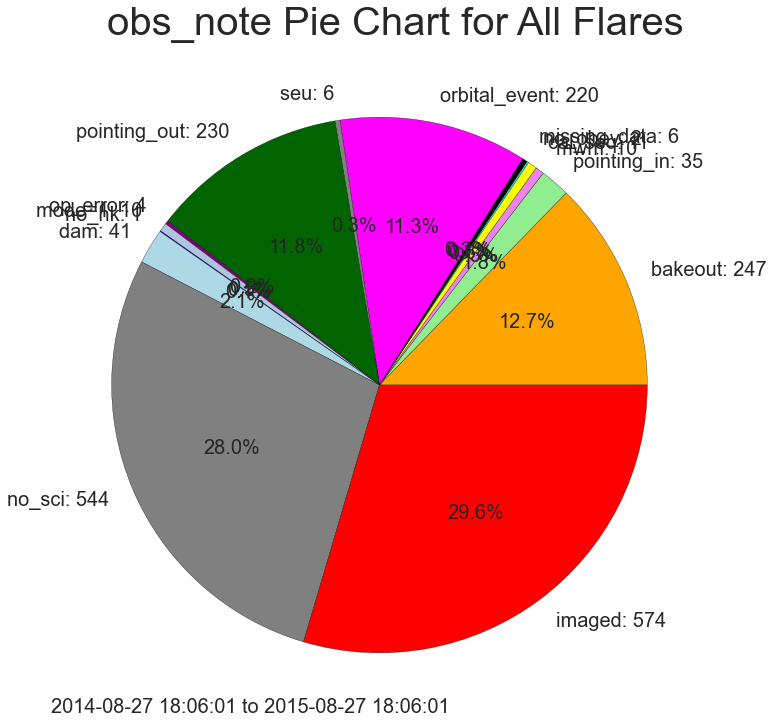

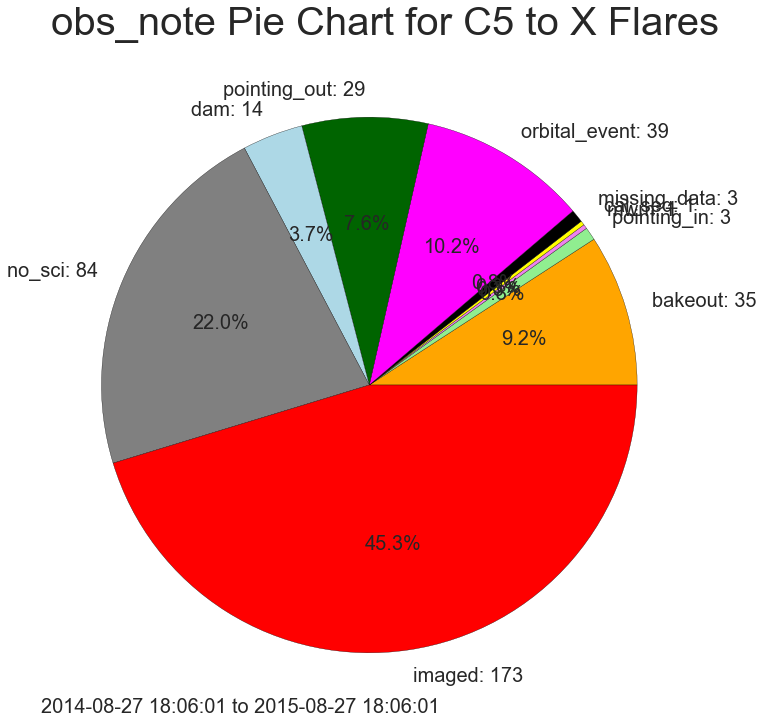

In [145]:
# Master Cell -- use this cell to call all desired functions


# Set time period for plots
t_f = datetime.datetime.utcnow()-datetime.timedelta(days=0)
t_i = t_f - datetime.timedelta(days=365)


# Generate pandas DataFrame of XRT Flare Catalog
data = getXrtFlareCat(t_i,t_f)

types = [('All','B','Z'),('C5 to X','C5','Z')]#,('B','B','C'),('C','C','M'),('M','M','X'),('X','X','Z')]

# Loop iterates over the list types creating plots for each type. Not always desired, but can save a lot of time.
# Remember to use the save (default False) and show (default True) keyword arguments as desired
for flareType in types:
    #Generate and save plots
    try:
        #genDistPlot(t_i,t_f,flareType,data=data,bw=125)
        #genProbPlot(t_i,t_f,flareType,data=data,bw=125,save=True)
        #genHistogram(t_i,t_f,flareType,data=data)
        #genFlareResPlot(t_i,t_f,flareType,data=data,bw=125)
        #genObsNoteDistPlot(t_i,t_f,flareType,bw=150,save=True)
        genObsNotePie(t_i,t_f,flareType,pointings)
        #genObsNotesClassPlot(t_i,t_f,flareType)
        continue;
    except ValueError:
        print 'ValueError'
    continue;
    
#genFRPercentPlot(t_i,t_f)
#genFRValuePlot(t_i,t_f)
#genObsNotesPlot(t_i,t_f)
#genObsNotesClassPlot(t_i,t_f,('C5 to X','C5','Z'))
#genObsNotesClassPlot(t_i,t_f,('C5 to X','C5','Z'))
#genObsNoteDistPlot(t_i,t_f,('C5 to X','C5','Z'),bw=150)

t_f = datetime.datetime(2013,7,1)
t_i = datetime.datetime(2013,1,1)
#genObsNotePie(t_i,t_f,('C5 to X','C5','X'))

t_f = datetime.datetime(2014,1,1)
t_i = datetime.datetime(2013,7,1)
#genObsNotePie(t_i,t_f,('C5 to X','C5','X'))

t_f = datetime.datetime.utcnow()-datetime.timedelta(days=365*0)
t_i = t_f - datetime.timedelta(days=365*1)
#genCCDPlot(t_i,t_f,('C5 to X','C5','Z'))

In [ ]:
# STEREO Mission analysis cell

t_f = datetime.datetime.utcnow()
t_i = datetime.datetime(2009,1,1)

flareType = ('C5 to X','C5','Z')
z = 2

data = getXrtFlareCat(t_i,t_f)

data = data[(data['class'] > flareType[1]) & (data['class'] < flareType[2])]

# Create DataFrames for flares that occurred in and out of the CCD FOV, respectively
filterList = ['no:pointing','no:bakeout','no:fld_only','no:no_obs_planned','no:saa','no:xtw','no:ngt',
              'yes:no_response','yes:with_response']
inFOV, outFOV = splitByPointings(data,pointings=pointings,filterList=filterList)

# STEREO: ~45 degrees to ~135 degrees
t_f = datetime.datetime(2013,3,1)
t_i = datetime.datetime(2009,2,1)

# non-STEREO
t_f2 = datetime.datetime.utcnow()
t_i2 = datetime.datetime(2013,3,1)

# Create and name figure and axes
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

leg = []
labels = []

# Create plots
for period in [(t_i,t_f,'STEREO',[-755,-255,245,745],'red'),(t_i2,t_f2,'non-STEREO',[-745,-245,255,755],'blue')]:
    
    regionDict = {'All': None, 'E': None, 'CE': None, 'CW': None, 'W': None}
    flares = 0
    
    # Analyze performance by region
    for region in [(-1200,1200,'All'),(-1200,-500,'E'),(-500,0,'CE'),(0,500,'CW'),(500,1200,'W')]:
        
        # Filter DataFrames by region and by time period
        subsetIn = inFOV[((inFOV['x'] > region[0]) & (inFOV['x'] < region[1]) & 
                          (inFOV['t_start'] > period[0].strftime('%Y/%m/%d %H:%M')) & 
                          (inFOV['t_start'] < period[1].strftime('%Y/%m/%d %H:%M')))]
        
        subsetOut = outFOV[((outFOV['x'] > region[0]) & (outFOV['x'] < region[1]) & 
                          (outFOV['t_start'] > period[0].strftime('%Y/%m/%d %H:%M')) & 
                          (outFOV['t_start'] < period[1].strftime('%Y/%m/%d %H:%M')))]
        
        # Calculate and store statistics
        right = len(subsetIn)
        wrong = len(subsetOut)
        total = float(right) + float(wrong)
        
        p = right / total
        error = z*(p*(1-p)/total)**0.5 
        
        regionDict[region[2]] = (p,error)
        flares += total
    
    # Neatly create and store plotting arguments
    x = period[3]
    y = [e[0] for e in [regionDict[key] for key in ['E','CE','CW','W']]]
    err = [e[1] for e in [regionDict[key] for key in ['E','CE','CW','W']]]
    color = period[4]
    
    # Create errorbars and plot
    ax.errorbar(x,y,yerr=err,capthick=2,capsize=10,ecolor=color)
    plot = ax.plot(x,y,'-o',color=color)
    
    # Append to legend and labels
    leg.append(plot[0])
    labels.append(period[2] + ': ' + str(int(flares/2)))

# Create legend, text, and title
ax.legend(leg,labels,fontsize=25,markerscale=2,loc=4)
ax.text(0.025,0.033,str(z) + '-sigma\n' + flareType[0] + ' Flares',size=25,
        transform=ax.transAxes,linespacing = 1.7)
fig.suptitle('Pointing Success vs. Longitudinal Location', size = 40)

# Customize axes
ax.axis([-1000,1000,0,1])
ax.set_yticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax.set_yticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0],size=15)
ax.set_xticklabels([-1000,-500,0,500,1000],size=15)
ax.grid()

In [ ]:
# Focus Mode analysis cell

t_f = datetime.datetime.utcnow()
t_i = datetime.datetime(2014,1,1)

flareType = ('C5 to X','C5','Z')
z = 2

# Create and name figure and axes
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

leg = []
labels = []

# Create plots
for period in [('Normal Focus Mode',[-755,-255,245,745],'red',True,False),
               ('Normal Mode',[-745,-245,255,755],'blue',False,True)]:
    print period[0]
    print '\n\n'
    
    data = getXrtFlareCat(t_i,t_f,fmn=period[3],nm=period[4])

    data = data[(data['class'] > flareType[1]) & (data['class'] < flareType[2])]
    
    print len(data)
    
    # Create DataFrames for flares in and out of the CCD FOV, respectively
    filterList = ['no:pointing','no:bakeout','no:fld_only','no:no_obs_planned','no:saa','no:xtw','no:ngt',
              'yes:no_response','yes:with_response']
    inFOV, outFOV = splitByPointings(data,pointings=pointings,filterList=filterList)

    regionDict = {'All': None, 'E': None, 'CE': None, 'CW': None, 'W': None}
    
    flares = 0
    
    for region in [(-1200,1200,'All'),(-1200,-500,'E'),(-500,0,'CE'),(0,500,'CW'),(500,1200,'W')]:
        print region
        
        # Filter DataFrames by region
        subsetIn = inFOV[(inFOV['x'] > region[0]) & (inFOV['x'] < region[1])]
        subsetOut = outFOV[(outFOV['x'] > region[0]) & (outFOV['x'] < region[1])]
        
        # Calculate statistics
        right = len(subsetIn)
        wrong = len(subsetOut)
        total = float(right) + float(wrong)
        
        p = right / total
        error = z*(p*(1-p)/total)**0.5 
        
        regionDict[region[2]] = (p,error)
        flares += total
        print right
        print total
        print p
        print ''
    
    # Neatly create and store plotting arguments
    x = period[1]
    y = [e[0] for e in [regionDict[key] for key in ['E','CE','CW','W']]]
    err = [e[1] for e in [regionDict[key] for key in ['E','CE','CW','W']]]
    color = period[2]
    
    # Create errorbars and plot 
    ax.errorbar(x,y,yerr=err,capthick=2,capsize=10,ecolor=color)
    plot = ax.plot(x,y,'-o',color=color)
    
    # Append information to legend and labels
    leg.append(plot[0])
    labels.append(period[0] + ': ' + str(int(flares/2)))

# Create legend, text, and title
ax.legend(leg,labels,fontsize=25,markerscale=2,loc=4)
ax.text(0.025,0.033,str(z) + '-sigma\n' + flareType[0] + ' Flares',size=25,
        transform=ax.transAxes,linespacing = 1.7)
fig.suptitle('Pointing Success vs. Longitudinal Location', size = 40)

# Customize axes
ax.axis([-1000,1000,0,1])
ax.set_yticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])
ax.set_yticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0],size=15)
ax.set_xticklabels([-1000,-500,0,500,1000],size=15)
ax.grid()

In [ ]:
# Movie generation cell #1

t_f = datetime.datetime.utcnow()
t_i = datetime.datetime(2006,10,19)

data = getXrtFlareCat(t_i,t_f)

In [ ]:
# Movie generation cell #2
#
# A memory leak exists in genDistPlot if save == True as of 2015-08-25 -- Only create 150-250 frames at a time

for day in range(2689,2715): # Use the range to specify which frames to generate
    
    start = datetime.datetime(2006,10,20) + datetime.timedelta(days=day)
    end = start + datetime.timedelta(days=182)
    
    # getXrtFlareCat is only called once (previous cell) to save time/resources. Date filtering is therefore
    # necessary on each iteration
    dataFiltered = data[((data['t_start'] > start.strftime('%Y/%m/%d %H:%M')) & 
                         (data['t_start'] < end.strftime('%Y/%m/%d %H:%M')))]

    #Generate and save plot
    try:
        genDistPlot(start,end,('Solar','B','Z'),scale=True,show=False,save=True,data=dataFiltered)
        gc.collect()
    except ZeroDivisionError:
        print 'skipped'